# Archaic admixture in swept and non-swept haplotypes and regions

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

## Sweep and admixture data

In [9]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
admix_windows_chrX.head()

,chrom,name,start,end,tot_admix_len,admix_prop,archaic_snps,altai_snps,vindija_snps,denisova_snps,nr_admix_tracts,round_pos,called
0,X,B_Australian-3,0,100000,0,NaN,NaN,NaN,NaN,NaN,0,0,13.42
1,X,B_Australian-3,100000,200000,0,NaN,NaN,NaN,NaN,NaN,0,100000,50.69
2,X,B_Australian-3,200000,300000,0,NaN,NaN,NaN,NaN,NaN,0,200000,97.54
3,X,B_Australian-3,300000,400000,0,0.0,0.0,0.0,0.0,0.0,0,300000,267.62
4,X,B_Australian-3,400000,500000,0,0.0,0.0,0.0,0.0,0.0,0,400000,232.68


In [10]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

merged_data = (sweep_data.merge(admix_windows_chrX, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

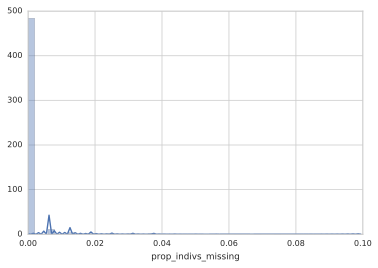

In [11]:
g = sns.distplot(merged_data.prop_indivs_missing)

## Global admixture proportions

In [12]:
merged_data.loc[lambda df: df.region_1 != 'Africa', 'admix_prop'].mean()

0.009336956898043966

In [13]:
merged_data.groupby('region_1')['admix_prop'].mean()

region_1
Africa                     NaN
WestEurasia           0.008298
SouthAsia             0.009369
CentralAsiaSiberia    0.005479
Oceania               0.015136
EastAsia              0.009338
America               0.006839
Name: admix_prop, dtype: float64

## Admixture proportions in stratified by `never_swept`

In [14]:
merged_data.groupby('never_swept')['admix_prop'].agg(['mean', 'count'])

,mean,count
never_swept,,
False,0.004130,45711
True,0.011748,98714


In [15]:
merged_data.groupby('never_swept_af')['admix_prop'].agg(['mean', 'count'])

,mean,count
never_swept_af,,
False,0.004974,48161
True,0.011520,96264


In [16]:
merged_data.groupby(['never_swept', 'never_swept_af'])['admix_prop'].agg(['mean', 'count'])

mean  count
never_swept never_swept_af                 
False       False           0.004130  45711
True        False           0.020727   2450
            True            0.011520  96264

Test difference between `never_swept` `True` and `False`:

In [17]:
scipy.stats.ttest_ind(merged_data.loc[merged_data.never_swept == True, 'admix_prop'],
                      merged_data.loc[merged_data.never_swept == False, 'admix_prop'],
                      nan_policy='omit'
                     )

Ttest_indResult(statistic=16.746322941681452, pvalue=6.90759224822001e-63)

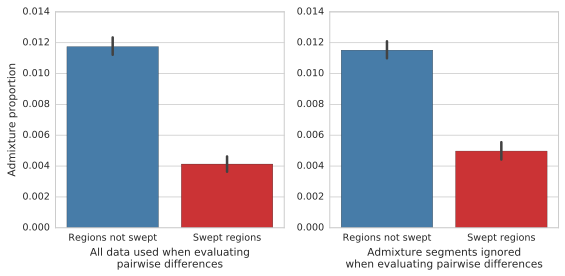

In [18]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            g1 = sns.barplot(x="not_never_swept", y="admix_prop", 
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), 
                             ax=ax1, n_boot=1000)
            g2 = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g1.set_ylabel("Admixture proportion")
            g2.set_ylabel("")
            g1.set_xlabel("All data used when evaluating\npairwise differences")
            g2.set_xlabel("Admixture segments ignored\nwhen evaluating pairwise differences")
            
            g1.set_xticklabels(['Regions not swept', 'Swept regions'])
            g2.set_xticklabels(['Regions not swept', 'Swept regions'])

            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.pdf'))
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.png'))



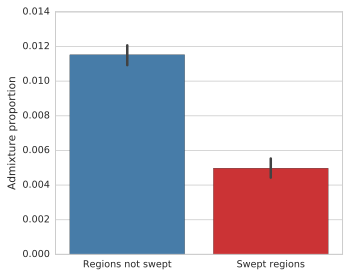

In [19]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, ax2 = plt.subplots(1, figsize=(5,4))
            g = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g.set_ylabel("Admixture proportion")
            g.set_xlabel('')
            g.set_xticklabels(['Regions not swept', 'Swept regions'])
                        
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions_af.pdf'))


## Admixture proportions only in windows that are `swept` in some males and not in others

In [20]:
df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept', 'admix_prop']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

df_af = (merged_data.loc[lambda df: (df.partial_sweep_win_af == True),# & (df.conserv_swept_group_af != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept_af', 'admix_prop']]
         
         
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
         
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept_af'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df = pandas.concat([df, df_af])
plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

plot_df.head()

,indiv_1,region_1,start,admix_prop,call,is_swept
0,B_Australian-4,Oceania,10200000,0.0,swept,False
1,B_Australian-4,Oceania,10300000,0.0,swept,False
2,B_Australian-4,Oceania,10400000,0.0,swept,False
3,B_Australian-4,Oceania,10500000,0.0,swept,False
4,B_Australian-4,Oceania,10600000,0.0,swept,False


In [21]:
plot_df.groupby(['call', 'is_swept'])['admix_prop'].agg(['mean', 'sem'])

mean       sem
call     is_swept                    
swept    False     0.006357  0.000396
         True      0.000112  0.000046
swept_af False     0.006465  0.000394
         True      0.000671  0.000156

Plots are based on this many 100kb windows along the chromosome:

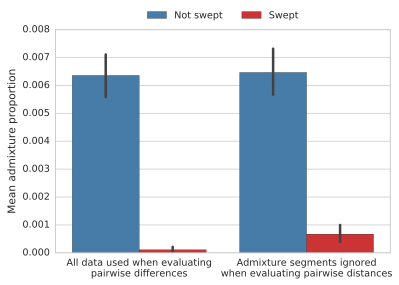

In [22]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='call', y='admix_prop', hue='is_swept', data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 'Admixture segments ignored\nwhen evaluating pairwise distances'])
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()

            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
                     ncol=2
                    )
            plt.savefig(str(figures_dir / 'admix_prop_by_call.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call.png'))

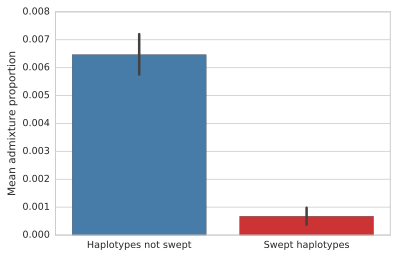

In [23]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='is_swept', y='admix_prop', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af']
                           )
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['Haplotypes not swept', 'Swept haplotypes'])

            plt.savefig(str(figures_dir / 'admix_prop_af.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_af.png'))

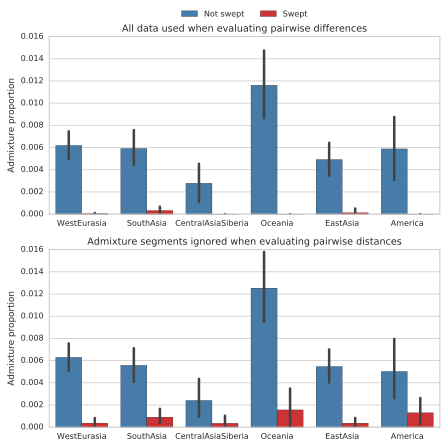

In [24]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharey=True)

            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.png'))

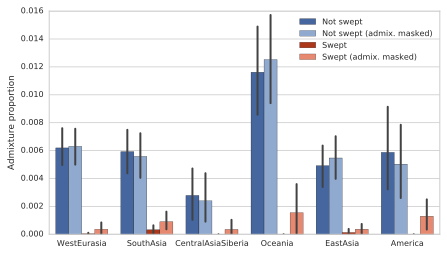

In [25]:
with sns.color_palette(["#3662AE", "#86A7D9", "#C52900", "#FB7D5D"]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))

            g = sns.barplot(x='region_1', y='admix_prop', hue='label', 
                            data=plot_df.assign(label=plot_df.call.astype(str) + "_" + plot_df.is_swept.astype(str)), 
                            hue_order=['swept_False', 'swept_af_False', 'swept_True', 'swept_af_True'],
                            ax=ax1,
                            errwidth=2,
                            #width = .8
                           )

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 
                               'Not swept (admix. masked)',
                               'Swept',
                               'Swept (admix. masked)',
                              ],
                     #bbox_to_anchor=(1., 1.0),  loc='upper left',
                     loc='upper right',
#                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=1
                    )

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region_version2.pdf'))

Admixture proportions:

In [26]:
(plot_df
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
)

mean       sem
call     region_1           is_swept                    
swept    WestEurasia        False     0.006189  0.000654
                            True      0.000040  0.000030
         SouthAsia          False     0.005921  0.000830
                            True      0.000319  0.000154
         CentralAsiaSiberia False     0.002783  0.000946
                            True      0.000000  0.000000
         Oceania            False     0.011614  0.001561
                            True      0.000000  0.000000
         EastAsia           False     0.004913  0.000770
                            True      0.000128  0.000128
         America            False     0.005876  0.001484
                            True      0.000000  0.000000
swept_af WestEurasia        False     0.006298  0.000653
                            True      0.000362  0.000222
         SouthAsia          False     0.005577  0.000788
                            True      0.000899  0.000346
         CentralAsiaSiberia False     0.002406  0.000866
                            True      0.000345  0.000345
         Oceania            False     0.012529  0.001605
                            True      0.001556  0.000872
         EastAsia           False     0.005469  0.000789
                            True      0.000357  0.000206
         America            False     0.005029  0.001395
                            True      0.001290  0.000593

In the admixture filtered analysis, confidence intervals for mean admixture proportions overlap, or nearly overlap zero. Add to that that Laurit's method has a false positive rate of 5-10%.

In [27]:
(plot_df.loc[lambda df: (df.call=='swept_af') & (df.is_swept==True)]
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
 .reset_index()
 .assign(non_zero=lambda df: df['mean']-1.96*df['sem'])
)

,call,region_1,is_swept,mean,sem,non_zero
0,swept_af,WestEurasia,True,0.000362,0.000222,-0.000074
1,swept_af,SouthAsia,True,0.000899,0.000346,0.000221
2,swept_af,CentralAsiaSiberia,True,0.000345,0.000345,-0.000331
3,swept_af,Oceania,True,0.001556,0.000872,-0.000155
4,swept_af,EastAsia,True,0.000357,0.000206,-0.000047
5,swept_af,America,True,0.001290,0.000593,0.000127


### Chromosome wide admixture proportion excluding the swept haplotypes we call:

Compute mean admixture of each 100kb window when sweept windows are excluded and then compute chromosome mean:

In [28]:
chrom_admix_without_sweeps = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix_without_sweeps

,mean,sem,lower,upper
admix_prop,0.008986,0.001998,0.00507,0.012901


In [29]:
chrom_admix = (plot_df
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix

,mean,sem,lower,upper
admix_prop,0.006224,0.001854,0.00259,0.009857


In [30]:
(chrom_admix_without_sweeps['mean'] - chrom_admix['mean']) / chrom_admix_without_sweeps['mean']

admix_prop    0.307348
Name: mean, dtype: float64

Same but by region:

In [31]:
chrom_admix_without_sweeps_by_region = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_without_sweeps_by_region

,mean,sem,lower,upper
region_1,,,,
WestEurasia,0.007910,0.001828,0.004328,0.011492
SouthAsia,0.009493,0.002447,0.004697,0.014289
CentralAsiaSiberia,0.003597,0.001558,0.000542,0.006652
Oceania,0.011680,0.002161,0.007444,0.015916
EastAsia,0.005602,0.001302,0.003050,0.008153
America,0.004384,0.001969,0.000524,0.008243


Same computation but inlcuding all windows for al individuals:

In [32]:
chrom_admix_by_region = (plot_df
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_by_region

,mean,sem,lower,upper
region_1,,,,
WestEurasia,0.005738,0.001646,0.002513,0.008964
SouthAsia,0.006166,0.002141,0.001969,0.010362
CentralAsiaSiberia,0.001646,0.000652,0.000369,0.002924
Oceania,0.008904,0.001757,0.005460,0.012348
EastAsia,0.003384,0.000700,0.002013,0.004756
America,0.003303,0.001347,0.000663,0.005942


How much higher would the chromosome average admixture level be if we take out swept haplotypes:

In [33]:
(chrom_admix_without_sweeps_by_region['mean'] - chrom_admix_by_region['mean']) / chrom_admix_without_sweeps_by_region['mean']

region_1
WestEurasia           0.274505
SouthAsia             0.350502
CentralAsiaSiberia    0.542267
Oceania               0.237702
EastAsia              0.395825
America               0.246545
Name: mean, dtype: float64

### Plot below is not for use but only for keeping as template in case I do a more thorough analysis on Laurits larger Papuan set.

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

            ax1.grid(False)
            sns.boxplot(x='region_1', y='altai_snps', hue='swept_af', data=sweep_and_admix_data_subset, ax=ax1,
                         color="red")
#             sns.boxplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="pink")
#             sns.boxplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="orange")

            for item in g.get_xticklabels():
                item.set_rotation(25)

            g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
                data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
                            ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Mean admixture proportions")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

In [ ]:
sweep_and_admix_data_subset = (merged_data
                               .groupby(['start'])
                               .filter(lambda df: df.swept.sum() > 0)
                              )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept', 
#                             data=merged_data.loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')], 
#                             ax=ax1, n_boot=1000)
            ax1.grid(False)
            ax1.set_title("All")

            extra_ax = ax1.twinx()
            sns.barplot(x='region_1', y='altai_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="red")
            sns.barplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="pink")
            sns.barplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="orange")
            extra_ax.grid(False)
            extra_ax.legend_.remove()

            for item in g.get_xticklabels():
                item.set_rotation(25)

#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
#                 data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
#                             ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Admixture segments removed")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

### Admixture proportion with distance from peaks

In [ ]:
sweep_peaks = pandas.read_hdf(results_dir / "sweep_peaks.hdf").assign(chrom='X').sort_values(by='start')
len(sweep_peaks)

In [ ]:
male_x_admix_segments = pandas.read_hdf(results_dir / 'male_x_admix_segments.hdf').sort_values(by='start')
len(male_x_admix_segments)

In [ ]:
non_ovl_admix_segm = GenomicIntervals.interval_diff(male_x_admix_segments, sweep_peaks)
len(non_ovl_admix_segm)

In [ ]:
GenomicIntervals.interval_intersect(non_ovl_admix_segm, sweep_peaks)

In [ ]:
GenomicIntervals.interval_intersect(non_ovl_admix_segm, sweep_peaks)

In [ ]:
GenomicIntervals.interval_distance(non_ovl_admix_segm, sweep_peaks)

## Which swept windows have admixture when calling with admix filter?

In [ ]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_data.loc[lambda df: (df.never_win_swept_af == False) & \
#                            (df.conserv_swept_group_af != 'ambig') &  \
                            (df.admix_prop > 0)]
            .sort_values(by=['admix_prop'], ascending=False))

## Correlation between proportion of windows swept and admixture proportion in each individual

There is a relation between amount swept and admixtue, as would be expected if sweeps displace admixture.

In [ ]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
#           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.pdf'))


The same but with the following two outliers removed:

In [ ]:
print(plot_df.loc[plot_df.admix_prop > 0.03])

In [ ]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

ax1.set_ylim(0, 0.03)
ax1.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.03)
ax2.set_xlim(0, 0.2)

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.pdf'))


In [ ]:
g = sns.lmplot(data=plot_df, 
               x='swept', y='admix_prop', hue='region_1', 
               fit_reg=False, palette='Set1')